# Next artist prediction in radio playlists à la Word2vec

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

print(tf.__version__)

0.12.0-rc0


## Downloading and loading playlists and songs metadata

See http://www.cs.cornell.edu/~shuochen/lme/data_page.html

In [2]:
! wget http://www.cs.cornell.edu/~shuochen/lme/dataset.tar.gz
! tar -xvf dataset.tar.gz

--2017-01-24 12:20:11--  http://www.cs.cornell.edu/~shuochen/lme/dataset.tar.gz
Resolving www.cs.cornell.edu... 132.236.207.20
Connecting to www.cs.cornell.edu|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15344424 (15M) [application/x-gzip]
Saving to: 'dataset.tar.gz.7'

dataset.tar.gz.7    100%[=====================>]  14.63M  1.42MB/s   in 10s    

2017-01-24 12:20:22 (1.45 MB/s) - 'dataset.tar.gz.7' saved [15344424/15344424]

x dataset/
x dataset/._.DS_Store
x dataset/.DS_Store
x dataset/README
x dataset/yes_big/
x dataset/yes_complete/
x dataset/yes_small/
x dataset/yes_small/song_hash.txt
x dataset/yes_small/tag_hash.txt
x dataset/yes_small/tags.txt
x dataset/yes_small/test.txt
x dataset/yes_small/train.txt
x dataset/yes_complete/song_hash.txt
x dataset/yes_complete/tag_hash.txt
x dataset/yes_complete/tags.txt
x dataset/yes_complete/test.txt
x dataset/yes_complete/train.txt
x dataset/yes_big/song_hash.txt
x dataset/yes_big/tag_hash.txt
x 

In [3]:
! head -5 dataset/yes_small/train.txt | cut -c 1-50

17430147 17277121 17767569 17352501 17567841 17650
19 456 22 82 120 854 597 20 160 76 415 493 81 29 1
0 1 2 3 4 5 6 7 8 
9 10 11 
12 13 14 15 


In [4]:
FIRST_FAULTY_PLAYLIST = 2
playlists = pd.read_csv('dataset/yes_small/train.txt', header=None, names=['songs'])\
    .assign(songs=lambda df: df.songs.str.split(' ').apply(lambda ids: list(map(int, filter(None, ids)))))\
    .iloc[FIRST_FAULTY_PLAYLIST:,:]

print('{} playlists for a total of {} songs'.format(playlists.shape[0], playlists.songs.apply(len).sum()))
playlists.head()
playlists.head()

41480 playlists for a total of 175911 songs


,songs
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8]"
3,"[9, 10, 11]"
4,"[12, 13, 14, 15]"
5,"[16, 17, 18]"
6,[19]


In [5]:
from itertools import chain

playlist_songs = pd.DataFrame.from_records(
    data=chain.from_iterable([(playlist_id, position, song_id) for position, song_id in enumerate(song_ids)] for playlist_id, (song_ids,) in playlists.iterrows()),
    columns=['playlist_id', 'position', 'song_id'])

print(playlist_songs.shape)
playlist_songs.head()

(175911, 3)


,playlist_id,position,song_id
0,2,0,0
1,2,1,1
2,2,2,2
3,2,3,3
4,2,4,4


In [6]:
FIRST_FAULTY_PLAYLIST = 2
test_playlists = pd.read_csv('dataset/yes_small/test.txt', header=None, names=['songs'])\
    .assign(songs=lambda df: df.songs.str.split(' ').apply(lambda ids: list(map(int, filter(None, ids)))))\
    .iloc[FIRST_FAULTY_PLAYLIST:,:]

print('{} playlists for a total of {} songs'.format(test_playlists.shape[0], test_playlists.songs.apply(len).sum()))
test_playlists.head()

389728 playlists for a total of 1581007 songs


,songs
2,"[3, 30, 38, 11, 39, 22, 40]"
3,"[12, 41, 42]"
4,"[43, 36]"
5,[44]
6,[4]


In [7]:
songs = pd.read_csv('dataset/yes_small/song_hash.txt', sep='\t', names=['song_id', 'title', 'artist'])\
    .set_index('song_id', drop=False)\
    .assign(artist_id=lambda df: df.artist.astype('category').cat.codes)

print(songs.shape)
songs.head(5)

(3168, 4)


,song_id,title,artist,artist_id
song_id,,,,
0,0,Gucci Time (w\/ Swizz Beatz),Gucci Mane,474
1,1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross,960
2,2,Get Back Up (w\/ Chris Brown),T.I.,1098
3,3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher,1264
4,4,Whip My Hair,Willow,1304


In [8]:
artists = songs.groupby('artist_id').first()[['artist']].reset_index()

artist_songs_played = songs.artist.loc[playlist_songs.song_id].to_frame('artist')\
    .groupby('artist').size()\
    .sort_values(ascending=False).to_frame('n_songs_played')

artists = pd.merge(artists, artist_songs_played.reset_index(), on='artist')
artists.head()

,artist_id,artist,n_songs_played
0,0,-,93
1,1,.38 Special,47
2,2,10 Years,152
3,3,2Pac,146
4,4,3 Doors Down,274


## Quick descriptive analysis

,playlist_id,position,song_id,title,artist,artist_id
0,4,0,12,All I Wants Is You (w\/ J Cole),Miguel,797
1,4,1,13,Champagne Life,Ne-Yo,832
2,4,2,14,Find Your Love,Drake,341
3,4,3,15,Your Love,Nicki Minaj,844


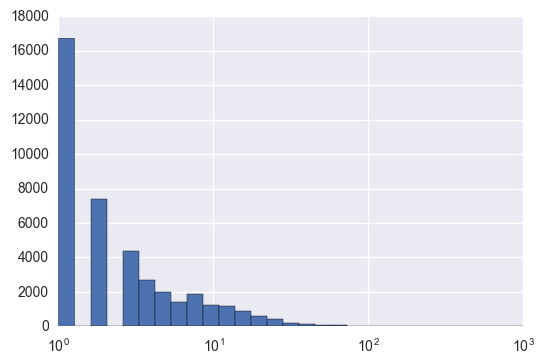

In [9]:
plt.hist(playlist_songs.groupby('playlist_id').size(), bins=np.logspace(0, 3, 30))
plt.xscale('log')

pd.merge(
    playlist_songs.query('playlist_id == 4'),
    songs,
    on='song_id')

In [10]:
songs.song_id.describe()

count    3168.000000
mean     1583.500000
std       914.667153
min         0.000000
25%       791.750000
50%      1583.500000
75%      2375.250000
max      3167.000000
Name: song_id, dtype: float64

In [11]:
playlist_songs.song_id.describe()

count    175911.000000
mean       1532.231151
std        1016.879762
min           0.000000
25%         541.000000
50%        1579.000000
75%        2505.000000
max        3167.000000
Name: song_id, dtype: float64

## Skip-gram generator

Generating all pairs of co-played words (ie artists) from the same context (ie playlist), without taking into account the order.

In [12]:
from itertools import permutations, chain

song_ids = playlist_songs.query('playlist_id == 3').song_id.values

def artist_skip_grams(song_ids):
    song_artist_ids = songs.artist_id.loc[song_ids].values
    return [(a1, a2) for a1, a2 in permutations(song_artist_ids, 2) if a1 != a2]

print(songs.artist_id.loc[song_ids])
print(artist_skip_grams(song_ids))

song_id
9      965
10     394
11    1264
Name: artist_id, dtype: int16
[(965, 394), (965, 1264), (394, 965), (394, 1264), (1264, 965), (1264, 394)]


In [13]:
from itertools import islice, cycle

class PlaylistToArtistPairs:

    def __init__(self, batch_size, playlists=playlists):
        all_artist_skip_grams = chain.from_iterable(map(artist_skip_grams, playlists.songs.values))
        self.all_artist_skip_grams_iterable = cycle(all_artist_skip_grams)
        self.batch_size = batch_size

    def __next__(self):
        next_skip_grams = list(islice(self.all_artist_skip_grams_iterable, self.batch_size))
        input_words, output_words = np.array(next_skip_grams, dtype=np.int32).T
        return input_words, output_words

    def next(self):
        return self.__next__()
    
skipGramGenerator = PlaylistToArtistPairs(batch_size=10)

next(skipGramGenerator)

(array([474, 474, 474, 474, 474, 474, 474, 474, 960, 960], dtype=int32),
 array([ 960, 1098, 1264, 1304,  553, 1308, 1054,  707,  474, 1098], dtype=int32))

In [14]:
#%timeit sum(1 for _ in PlaylistToArtistPairs().all_artist_skip_grams_iterable)

In [15]:
playlist_songs.song_id.head()

0    0
1    1
2    2
3    3
4    4
Name: song_id, dtype: int64

In [16]:
playlist_songs.head()

,playlist_id,position,song_id
0,2,0,0
1,2,1,1
2,2,2,2
3,2,3,3
4,2,4,4


In [17]:
songs.artist_id.loc[playlist_songs.song_id.head()]

song_id
0     474
1     960
2    1098
3    1264
4    1304
Name: artist_id, dtype: int16

## Word2vec as a simple shallow perceptron, on a toy dataset

 * at the heart, word2vec is a shallow 2 layers with a soft-max activation function that we feed with input and output pairs
 * From [word2vec Parameter Learning Explained](https://arxiv.org/abs/1411.2738):
 

In [18]:
from IPython.display import Image
from IPython.core.display import HTML
Image(url= "https://cdn-images-1.medium.com/max/2000/1*QXrebSekA-ClL154Ma89ZA.png", width=600, height=400)

In [21]:
input_output_pairs = np.array([
    [0, 1], [1, 0], [0, 1], [1, 2], [1, 2], [2, 3], [3, 2]])

vocabulary_size = np.unique(input_output_pairs).shape[0]
hidden_layer_size = embedding_size = 2

print('{} example pairs with {} unique ids'.format(input_output_pairs.shape, hidden_layer_size))
input_output_pairs

(7, 2) example pairs with 2 unique ids


array([[0, 1],
       [1, 0],
       [0, 1],
       [1, 2],
       [1, 2],
       [2, 3],
       [3, 2]])

## 1st exercise: Keras implementation

 * Define a `keras.models.Sequential` using the `Embedding, Reshape, Dense, Activation` from `keras.layers` (TIP order is correct ;)) 
 * TIP: I had to use `Reshape` in between `Embedding` to drop the superfluous dimension output from `Embedding(..., input_length=1)`
 * test right away the model by asking output probabilities given a single input id using `model.predict(x=[[1]])`
 * Execute `model.compile` and `model.fit` to run on epoch of backpropagation (TIP: pass `input_output_pairs[:, 0]` and `input_output_pairs[:, 1]` as inputs to `fit`)
 * Look at `input_layer.weights[0].eval()` to check results

In [24]:
import keras
from keras.layers import Embedding, Reshape, Dense, Activation
from keras.models import Sequential
from keras import backend as K

sess = tf.InteractiveSession()
K.set_session(sess)

print(keras.__version__)

1.1.0


In [25]:
input_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=1, init='uniform')

output_layer = Dense(output_dim=vocabulary_size, bias=False)

model = Sequential([
    input_layer,
    Reshape((embedding_size,)), # getting rid of the superfluous dimension of input_length=1
    output_layer,
    Activation('softmax')
])

In [26]:
model.predict(x=np.array([[1]]))

array([[ 0.24775435,  0.25582856,  0.25074571,  0.24567135]], dtype=float32)

In [27]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd')
model.fit(x=input_output_pairs[:, 0], y=input_output_pairs[:, 1])

Epoch 1/10
7/7 [==============================] - 0s - loss: 1.3754
Epoch 2/10
7/7 [==============================] - 0s - loss: 1.3747
Epoch 3/10
7/7 [==============================] - 0s - loss: 1.3739
Epoch 4/10
7/7 [==============================] - 0s - loss: 1.3731
Epoch 5/10
7/7 [==============================] - 0s - loss: 1.3724
Epoch 6/10
7/7 [==============================] - 0s - loss: 1.3716
Epoch 7/10
7/7 [==============================] - 0s - loss: 1.3708
Epoch 8/10
7/7 [==============================] - 0s - loss: 1.3701
Epoch 9/10
7/7 [==============================] - 0s - loss: 1.3693
Epoch 10/10
7/7 [==============================] - 0s - loss: 1.3686


In [28]:
# looks ok, 0 and 3 are the most different, while 1 and 2 in-between
input_layer.weights[0].eval()

array([[-0.04523154, -0.05406943],
       [-0.01869763, -0.02119141],
       [-0.0391637 ,  0.04367046],
       [ 0.00987293,  0.03031986]], dtype=float32)

## Keras artist2vec 

 * almost copy and paste of the toy example!
 * use `model.fit_generator` with `PlaylistToArtistPairs`
 * TIP model.fit_generator(generator=PlaylistToArtistPairs(batch_size=BATCH_SIZE),
                    samples_per_epoch=10*BATCH_SIZE, nb_epoch=10)

In [29]:
from keras.optimizers import Adam
N_ARTISTS = songs.artist_id.max() + 1
EMBEDDING_DIM = 20

input_layer = Embedding(input_dim=N_ARTISTS, output_dim=EMBEDDING_DIM, input_length=1, init='uniform')

output_layer = Dense(output_dim=N_ARTISTS, bias=False)

model = Sequential([
    input_layer,
    Reshape((EMBEDDING_DIM,)), # getting rid of the superfluous dimension of input_length=1
    output_layer,
    Activation('softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.01))

In [30]:
BATCH_SIZE = 10000

model.fit_generator(generator=PlaylistToArtistPairs(batch_size=BATCH_SIZE),
                    samples_per_epoch=10*BATCH_SIZE, nb_epoch=10)

Epoch 1/10
100000/100000 [==============================] - 6s - loss: 7.1770     
Epoch 2/10
100000/100000 [==============================] - 6s - loss: 7.0867     
Epoch 3/10
100000/100000 [==============================] - 6s - loss: 6.7710     
Epoch 4/10
100000/100000 [==============================] - 6s - loss: 6.3392     
Epoch 5/10
100000/100000 [==============================] - 5s - loss: 6.3288     
Epoch 6/10
100000/100000 [==============================] - 6s - loss: 5.5508     
Epoch 7/10
100000/100000 [==============================] - 6s - loss: 5.4935     
Epoch 8/10
100000/100000 [==============================] - 6s - loss: 5.4221     
Epoch 9/10
100000/100000 [==============================] - 6s - loss: 5.0866     
Epoch 10/10
100000/100000 [==============================] - 6s - loss: 4.9812     


## 2nd exercise : Tensorflow implementation

### Model components and forward part:

 * define `tf.placeholder` for `input_ids`
 * define two `tf.Variable` for the model weights `W_input` and `W_output` using the size `vocabulary_size x embedding_size`
 * initialise these variables by doing `sess.run([W_input.initializer, W_output.initializer])`
 * print `W_input.eval()`
 * use `tf.nn.embedding_lookup`, `tf.matmul` and `tf.nn.softmax` assemble the whole to return tensors `output_word_scores` and `output_probabilities`
 * Test by printing `output_probabilities.eval(...)` or `sess.run(output_probabilities, ...)` by feeding `feed_dict = {input_ids: [input_word]}`


In [31]:
BATCH_SIZE = None
sess = tf.InteractiveSession()

input_ids = tf.placeholder(tf.int32, shape=[BATCH_SIZE])

W_input = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
W_output = tf.Variable(tf.random_uniform([embedding_size, vocabulary_size], -1.0, 1.0))
sess.run([W_input.initializer, W_output.initializer])

W_input.eval()

input_vector = tf.nn.embedding_lookup(W_input, input_ids)
output_word_scores = tf.matmul(input_vector, W_output)
output_probabilities = tf.nn.softmax(output_word_scores)

input_word = 1
feed_dict = {input_ids: [input_word]}

print('W_input:\n', W_input.eval())
print('W_input[input_word]:', input_vector.eval(feed_dict))
print('output_word_scores:', output_word_scores.eval(feed_dict))
print('output P[W_O|W_I = input_word]:',output_probabilities.eval(feed_dict))

W_input:
 [[ 0.08652782 -0.34646392]
 [-0.64871407  0.78041172]
 [ 0.46208     0.63580108]
 [ 0.26514316 -0.2523613 ]]
W_input[input_word]: [[-0.64871407  0.78041172]]
output_word_scores: [[ 0.75768137  0.57094318 -0.5361951  -0.12813765]]
output P[W_O|W_I = input_word]: [[ 0.3974179   0.32972211  0.10897429  0.16388571]]


### Training through backpropagation:

 * define `tf.placeholder` for `output_ids` (same size as `input_ids`)
 * define an average loss tensor from `output_word_scores` and `output_ids` using `tf.reduce_mean` and `tf.nn.sparse_softmax_cross_entropy_with_logits`
 * test by printing `loss.eval(feed_dict)` by feeding `feed_dict = {input_ids: input_output_pairs[:, 0], output_ids: input_output_pairs[:, 1]}`
 * define a `train_step = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(loss)`, run it once using `sess.run(train_step, feed_dict)` and print `W_input.eval()` and `loss` to see the changes

In [32]:
tf.nn.sparse_softmax_cross_entropy_with_logits?

In [33]:
output_ids = tf.placeholder(tf.int32, shape=[BATCH_SIZE])
feed_dict = {input_ids: input_output_pairs[:, 0], output_ids: input_output_pairs[:, 1]}

loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=output_word_scores,
        labels=output_ids))

print('loss:', loss.eval(feed_dict))

train_step = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(loss)
         
sess.run(train_step, feed_dict)
print('loss:', loss.eval(feed_dict))
print('W_input:\n', W_input.eval())

sess.run(train_step, feed_dict)
print('loss:', loss.eval(feed_dict))
print('W_input:\n', W_input.eval())

sess.run(train_step, feed_dict)
print('loss:', loss.eval(feed_dict))
print('W_input:\n', W_input.eval())

loss: 1.59776
loss: 1.43065
W_input:
 [[ 0.11283824 -0.15312684]
 [-0.48019004  0.63776666]
 [ 0.47041962  0.59412318]
 [ 0.35223305 -0.28939322]]
loss: 1.36545
W_input:
 [[ 0.16241732 -0.03266931]
 [-0.39228451  0.57355899]
 [ 0.48847365  0.56620526]
 [ 0.4162063  -0.30685082]]
loss: 1.3317
W_input:
 [[ 0.21983972  0.04788139]
 [-0.3510949   0.54481167]
 [ 0.5145883   0.54538041]
 [ 0.46453491 -0.31270307]]


## Tensorflow artist2vec

 * For a nice introduction https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/ with lots of lovely diagrams.

 * https://www.tensorflow.org/tutorials/word2vec/ is a good self-contained ressource with explanations as well as code hints.

However, their implementation uses some high-level optimised function (namely the `tf.nn.nce_loss`) that makes the code less didactic without having any impact for the size of our dataset. 

Therefore it's a better exercise to:

 * Define `input_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))` and the symmetrical `hidden_embeddings` (instead of `nce_weights`) as in the schema below
 * Drop the `nce_biases` altogether
 * Multiply the `embed` tensor with the `hidden_embeddings` to calculate a `(N_SAMPLES x N_OUTPUT_SONGS)` `logits` tensor (hint: use `tf.matmul` and `tf.transpose`)
 * Feed `logits` and `train_labels` into `tf.nn.sparse_softmax_cross_entropy_with_logits` as we did for the [iris classification](https://github.com/pilipolio/schibsted-study/blob/master/notebooks/201611_multiclass_classification.ipynb)
 * (Or alternatively compute manually the softmax loss)

In [34]:
N_ARTISTS = songs.artist_id.max() + 1

class Artist2Vec:
    def __init__(self, n_entities, dimensionality=50, batch_size=None):
        
        with tf.name_scope('input_embeddings'):
            input_embeddings = tf.Variable(tf.random_normal([n_entities, dimensionality], 
                                                           stddev=0.01, mean=0), name='input')
            tf.histogram_summary('input_embeddings', input_embeddings)

        with tf.name_scope('output_embeddings'):
            output_embeddings = tf.Variable(tf.random_normal([n_entities, dimensionality], stddev=0.01, mean=0), name='output')
            tf.histogram_summary('output_embeddings', output_embeddings)

        with tf.name_scope('output_bias'):
            output_biases = tf.Variable(tf.random_normal([n_entities], stddev=0.01, mean=0), name='output_bias')
            tf.histogram_summary('output_biases', output_biases)
        
        self.n_entities = n_entities
        self.output_biases = output_biases
        self.input_embeddings = input_embeddings
        self.output_embeddings = output_embeddings
    
        self.input_artist_ids = tf.placeholder(
            tf.int32, shape=[batch_size], name='input_artist_ids')
        self.output_artist_ids = tf.placeholder(
            tf.int32, shape=[batch_size], name='output_artist_ids')

    def input_to_all_output_logits(self):
        """
        The architecture is made of:
         * input nodes for the user_id, and associated weights or embeddings V_u
         * internal weights W_i and biases b_i for each items
        """
        return self.output_biases + tf.matmul(
                tf.nn.embedding_lookup(self.input_embeddings, self.input_artist_ids),
                tf.transpose(self.output_embeddings), name='input_to_all_output_logits')
        
    def exact_loss(self):
        with tf.name_scope('loss'):
            cross_entropy_sum = tf.reduce_mean(
                tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.input_to_all_output_logits(),
                    labels=self.output_artist_ids))
        return cross_entropy_sum
    
    def sampled_loss(self):
        with tf.name_scope('loss'):
            sample_losses = tf.nn.sampled_softmax_loss(
                biases=self.output_biases,
                inputs=tf.nn.embedding_lookup(self.input_embeddings, self.input_artist_ids),
                labels=tf.reshape(self.output_artist_ids, (-1, 1)),
                weights=self.output_embeddings,
                num_classes=self.n_entities,
                num_sampled=10, num_true=1)
            return tf.reduce_mean(sample_losses)

In [35]:
def save_embeddings_metadata(model, summary_writer):
    """ From https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/index.html#tensorboard-embedding-visualization
    """
    embeddings_metadata_path = os.path.join(LOG_DIR, 'artist_embeddings.tsv')
    artists.to_csv(embeddings_metadata_path, sep='\t')

    config = projector.ProjectorConfig()
    for embeddings_variable in [model.output_embeddings, model.input_embeddings]:
        embedding = config.embeddings.add()
        embedding.tensor_name = embeddings_variable.name
        embedding.metadata_path = embeddings_metadata_path
    
    projector.visualize_embeddings(summary_writer, config)

In [36]:
import datetime as dt
import os

from tensorflow.contrib.tensorboard.plugins import projector

LEARNING_RATE = 0.005
BATCH_SIZE = 10000
N_ITER = 100
LOG_DIR = '/tmp/tf_logs'

with tf.Graph().as_default():
    model = Artist2Vec(n_entities=N_ARTISTS, dimensionality=20)
    loss = model.exact_loss()    #.sampled_loss()
    
    tf.scalar_summary('batch_loss', loss)
    summary = tf.merge_all_summaries()
    test_summary = tf.scalar_summary('test_loss', loss)
    train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)
    
    test_generator = PlaylistToArtistPairs(playlists=test_playlists, batch_size=BATCH_SIZE)
    skip_grams_generator = PlaylistToArtistPairs(batch_size=BATCH_SIZE * 10)
    
    def perform_step(step, summary_writer):
        batch_input_ids, batch_output_ids = next(skip_grams_generator)
        _, loss_value, summary_value = sess.run(
            fetches=[train_step, loss, summary], 
            feed_dict={
                model.input_artist_ids: batch_input_ids,
                model.output_artist_ids: batch_output_ids
            })
        summary_writer.add_summary(summary_value, global_step=step)
        
        if step% 10 == 0:
            test_input_ids, test_output_ids = next(test_generator)
            test_loss_value, test_summary_value = sess.run(
            fetches=[loss, test_summary], 
            feed_dict={
                model.input_artist_ids: test_input_ids,
                model.output_artist_ids: test_output_ids
            })

            print('step {step}, batch_loss = {loss_value:.2f}, test_loss = {test_loss_value:.2f}'.format(**locals()))
            summary_writer.add_summary(test_summary_value, global_step=step)
        summary_writer.flush()

    with tf.Session() as sess:

        summary_writer = tf.train.SummaryWriter(
            os.path.join(LOG_DIR,'{:%Y%m%d%H%M%S}'.format(dt.datetime.now())),
            sess.graph)

        sess.run(tf.global_variables_initializer())
        
        for step in range(N_ITER):
            perform_step(step, summary_writer)
        
        input_embeddings = model.input_embeddings.eval()
        output_embeddings = model.output_embeddings.eval()
        
        saver = tf.train.Saver()
        saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"), step)
        save_embeddings_metadata(model, summary_writer)

step 0, batch_loss = 7.19, test_loss = 7.18
step 10, batch_loss = 6.84, test_loss = 6.11
step 20, batch_loss = 5.34, test_loss = 4.23
step 30, batch_loss = 4.83, test_loss = 4.08
step 40, batch_loss = 4.84, test_loss = 4.09
step 50, batch_loss = 5.15, test_loss = 3.93
step 60, batch_loss = 4.59, test_loss = 4.46
step 70, batch_loss = 4.60, test_loss = 4.71
step 80, batch_loss = 4.55, test_loss = 4.57
step 90, batch_loss = 4.55, test_loss = 4.19


In [37]:
pd.DataFrame(input_embeddings).to_csv(os.path.join(LOG_DIR, "input_embeddings.tsv"), sep='\t', index=None, header=None)
pd.DataFrame(output_embeddings).to_csv(os.path.join(LOG_DIR, "output_embeddings.tsv"), sep='\t', index=None, header=None)

In [38]:
from IPython.core.display import HTML, display
import pandas as pd

pd.set_option('display.width', 1000)

from scipy import spatial

def embeddings_to_distances(embeddings):
    item_item_distances = pd.DataFrame(
        index=embeddings.index,
        columns=embeddings.index,
        data=spatial.distance.squareform(spatial.distance.pdist(embeddings.values, metric='cosine'))
    )
    return item_item_distances

def topn_most_similar(item_id, topn, item_item_distances):
    candidate_distances = item_item_distances.loc[item_id]
    return candidate_distances.sort_values().iloc[1:(topn+1)].to_frame('distance')

def display_items(from_id, to_items_df, items_metadata):
    display(HTML(items_metadata.loc[[from_id]].to_html()))
    display(HTML(to_items_df.join(items_metadata).to_html()))
    
def display_topn_most_similar(item_id, distances, topn, items_metadata):
    most_similar = topn_most_similar(item_id, topn, distances)
    display_items(item_id, most_similar, items_metadata)

In [39]:
distances = embeddings_to_distances(pd.DataFrame(data=input_embeddings))
distances = embeddings_to_distances(pd.DataFrame(data=output_embeddings))

In [40]:
ABBA = 19
display_topn_most_similar(item_id=ABBA, distances=distances, topn=5, items_metadata=artists)

,artist_id,artist,n_songs_played
19,19,Abba,39


,distance,artist_id,artist,n_songs_played
890,0.004822,890,Paula Abdul,21
1005,0.007908,1005,Seal,144
1117,0.008009,1117,The 4 Seasons,38
500,0.008588,500,Howard Jones,21
246,0.008753,246,Club Nouveau,34


In [41]:
WITNEY = 1300
display_topn_most_similar(item_id=WITNEY, distances=distances, topn=5, items_metadata=artists)

,artist_id,artist,n_songs_played
1300,1300,Whitney Houston,21


,distance,artist_id,artist,n_songs_played
573,0.003844,573,Joe,20
166,0.004320,166,Brian Bromberg,23
878,0.004613,878,Patrice Rushen,22
1123,0.004632,1123,The Art Of Noise,30
1282,0.004802,1282,Walter Beasley,44


In [42]:
TWOPAC = 3
display_topn_most_similar(item_id=TWOPAC, distances=distances, topn=5, items_metadata=artists)

,artist_id,artist,n_songs_played
3,3,2Pac,146


,distance,artist_id,artist,n_songs_played
80,0.008655,80,Baby Bash,132
455,0.012132,455,Gorilla Zoe,135
1180,0.019753,1180,The Notorious B.I.G.,193
751,0.025377,751,Mann,226
1096,0.031149,1096,T-Pain,129


In [43]:
BEATLES = 1129
#output_distances = embeddings_to_distances(pd.DataFrame(data=output_embeddings))
display_topn_most_similar(item_id=BEATLES, distances=distances, topn=10, items_metadata=artists)

,artist_id,artist,n_songs_played
1129,1129,The Beatles,105


,distance,artist_id,artist,n_songs_played
1093,0.002155,1093,Supertramp,88
82,0.002457,82,Bachman-Turner Overdrive,104
1070,0.003299,1070,Steppenwolf,88
1153,0.004395,1153,The Electric Light Orchestra,83
897,0.007777,897,Peter Frampton,71
1148,0.010482,1148,The Doobie Brothers,187
750,0.012040,750,Manfred Mann's Earth Band,38
218,0.012194,218,Cheap Trick,67
582,0.015894,582,John Cougar Mellencamp,46
1152,0.018002,1152,The Edgar Winter Group,52


In [44]:
ROLLING = 1190
display_topn_most_similar(item_id=ROLLING, distances=distances, topn=10, items_metadata=artists)

,artist_id,artist,n_songs_played
1190,1190,The Rolling Stones,375


,distance,artist_id,artist,n_songs_played
928,0.021333,928,Queen,378
743,0.026452,743,Lynyrd Skynyrd,233
1195,0.026862,1195,The Steve Miller Band,227
1204,0.028502,1204,The Who,147
1320,0.031876,1320,ZZ Top,264
154,0.032048,154,Boston,242
485,0.033251,485,Heart,140
267,0.035406,267,Creedence Clearwater Revival,233
1233,0.041879,1233,Tom Petty & The Heartbreakers,163
84,0.043409,84,Bad Company,114
